### To Do List

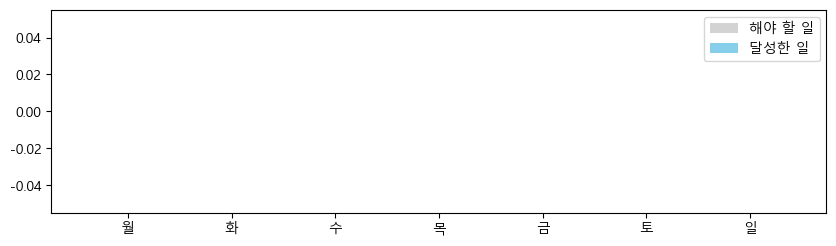

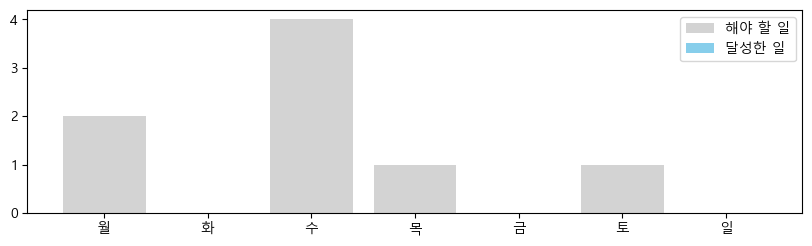

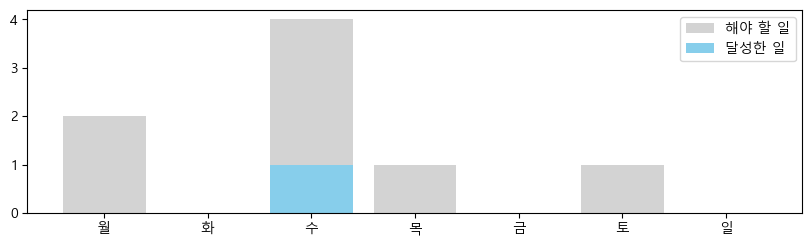

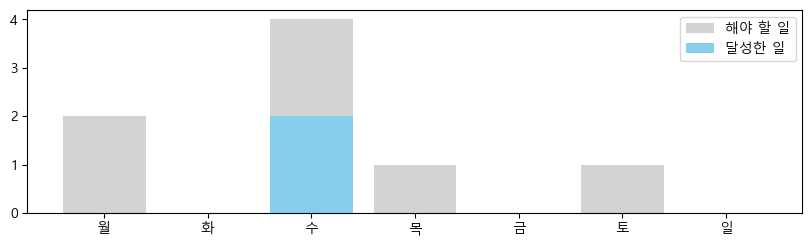

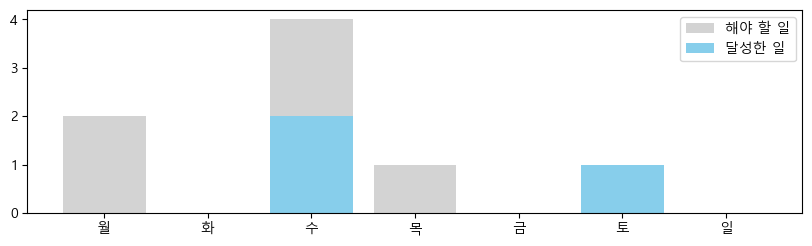

In [ ]:
from tkinter import *
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

# ------------------- 변수 선언 및 초기화 -------------------

days = ["월", "화", "수", "목", "금", "토", "일"]
todo_values = [[] for _ in range(7)]
default_values = [[] for _ in range(7)]
value_frames = []
check_status = [[] for _ in range(7)]
checkbuttons = [[] for _ in range(7)]
int_vars = [[] for _ in range(7)]
entry_vars_main = []       # 메인 화면용
entry_vars_default = []    # 기본값 설정 화면용
entry_widgets = []
day_task_frames = []

graph_canvas = None  # 그래프 위젯을 저장할 변수

box_width = 130
box_height = 400
wrap_px = box_width - 50

# ------------------- Tkinter 기본 세팅 -------------------

root = Tk()
root.title("할 일 체크리스트")
root.geometry("1050x700")
root.resizable(False, False)

main_frame = Frame(root)
main_frame.pack(fill="both", expand=True)

default_frame = Frame(root)
detail_frame = Frame(root)


# 레이아웃 비율 설정
main_frame.rowconfigure(0, weight=0)  # 제목
main_frame.rowconfigure(1, weight=1)  # 그래프
main_frame.rowconfigure(2, weight=0)  # 날씨
main_frame.rowconfigure(3, weight=5)  # 할 일
main_frame.columnconfigure(0, weight=1)

# -- 시간 관련 함수  ---

# 시간중복체크
def is_time_conflict(day_idx, new_time, values):
    for item in values[day_idx]:
        if item.startswith(new_time):  # "HH:MM"이 겹치면 중복
            return True
    return False

def is_time_available(day_idx, new_item):
    new_time = new_item.split()[0]
    if is_time_conflict(day_idx, new_time, todo_values):
        for existing_item in todo_values[day_idx]:
            if existing_item == new_item:
                return False
            if existing_item.startswith(new_time):
                messagebox.showwarning("시간 중복",f"[{days[day_idx]}요일] {new_time} 시간에 중복된 일정이 있습니다.\n"f"기존 일정: {existing_item}\n"f"추가하려는 기본값: {new_item}")
                return False
    return True

# ---------- 기본 값 -> 메인 화면 적용 함수 ----------  

def apply_default_tasks_for_day(day_idx):
    for item in default_values[day_idx]:
        if is_time_available(day_idx, item):
            todo_values[day_idx].append(item)
            check_status[day_idx].append(False)
    todo_values[day_idx].sort()
    redraw_task_box(day_idx)

def apply_default_values_to_main():
    for day_idx in range(7):
        apply_default_tasks_for_day(day_idx)

def apply_defaults_and_return_to_main():
    apply_default_values_to_main()
    show_main_view()

# ------------------- 체크 상태 처리 함수 -------------------

def toggle_task_checked(day_idx, task_idx):
    check_status[day_idx][task_idx] = not check_status[day_idx][task_idx]
    int_vars[day_idx][task_idx].set(int(check_status[day_idx][task_idx]))
    draw_weekly_achievement_graph(graph_frame)

# ------------------- 값 추가, 삭제 --------------------

def add_value(day_idx, entry_vars, target_values, check_status_list=None, refresh_ui_fn=None, redraw_graph_fn=None):
    value = entry_vars[day_idx].get().strip()
    if not value:
        return

    # "HH:MM 내용" 형식 확인
    match = re.match(r'^([0-2][0-9]:[0-5][0-9])\s(.+)$', value)
    if not match:
        messagebox.showwarning("입력 오류", "시간은 'HH:MM 내용' 형식으로 입력하세요.\n예: 09:30 운동")
        return

    time, task = match.groups()

    # 시간 중복 체크
    if is_time_conflict(day_idx, time, target_values):
        messagebox.showwarning("시간 중복", f"{days[day_idx]}요일에 {time}에 이미 일정이 있습니다!")
        return

    # 추가 및 정렬
    target_values[day_idx].append(value)
    target_values[day_idx].sort()
    entry_vars[day_idx].set("")

    # 체크 상태 추가 (todo 전용)
    if check_status_list is not None:
        check_status_list[day_idx].append(False)

    # UI 갱신
    if refresh_ui_fn:
        refresh_ui_fn(day_idx)

    # 그래프 갱신 (todo 전용)
    if redraw_graph_fn:
        redraw_graph_fn(graph_frame)

def add_default_value(day_idx):
    add_value(
        day_idx,
        entry_vars_default,
        default_values,
        refresh_ui_fn=refresh_day_values
    )

def add_todo_value(day_idx):
    add_value(
        day_idx,
        entry_vars_main,
        todo_values,
        check_status_list=check_status,
        refresh_ui_fn=redraw_task_box,
        redraw_graph_fn=draw_weekly_achievement_graph
    )

def delete_value(
    day_idx,
    item_idx,
    target_values,
    check_status_list=None,
    refresh_ui_fn=None,
    extra_ui_hooks=None
):
    # 항목 제거
    del target_values[day_idx][item_idx]

    # 체크 상태도 함께 제거 (todo 전용)
    if check_status_list is not None:
        del check_status_list[day_idx][item_idx]

    # 화면 갱신
    if refresh_ui_fn:
        refresh_ui_fn(day_idx)

    # 추가 UI 업데이트 함수들 (리스트 형태로 받아 실행)
    if extra_ui_hooks:
        for fn in extra_ui_hooks:
            fn(day_idx)
            
# 삭제할 값의 위치(이중 리스트라서 2개의 값)
def delete_default_value(day_idx, item_idx):
    delete_value(
        day_idx,
        item_idx,
        default_values,
        refresh_ui_fn=refresh_day_values
    )

def delete_todo_value(day_idx, item_idx):
    delete_value(
        day_idx,
        item_idx,
        todo_values,
        check_status_list=check_status,
        refresh_ui_fn=redraw_task_box,
        extra_ui_hooks=[redraw_day_detail_view, lambda i: draw_weekly_achievement_graph(graph_frame)]
    )

# ------------------ UI 갱신 함수 -------------------

def redraw_task_box(day_idx):
    frame = day_task_frames[day_idx]
    for widget in frame.winfo_children():
        widget.destroy()

    checkbuttons[day_idx].clear()
    int_vars[day_idx].clear()

    for i, task in enumerate(todo_values[day_idx]):
        create_task_checkbox(day_idx, i, task, frame)

def create_task_checkbox(day_idx, task_idx, task_text, parent_frame):
    var = IntVar(value=int(check_status[day_idx][task_idx]))
    int_vars[day_idx].append(var)

    cb = Checkbutton(
        parent_frame, text=task_text, variable=var,
        command=lambda d=day_idx, t=task_idx: toggle_task_checked(d, t),
        anchor="w", justify=LEFT, wraplength=wrap_px,
        # font=("Arial", 12)
    )
    cb.pack(anchor="w", pady=3)
    checkbuttons[day_idx].append(cb)

# 요일 상세 확인(강조)
def redraw_day_detail_view(day_idx):
    for widget in detail_frame.winfo_children():
        widget.destroy()

    Label(detail_frame, text=f"{days[day_idx]}요일 할일 목록", font=("Arial", 20, "bold")).pack(pady=10)

    for i, task in enumerate(todo_values[day_idx]):
        row = Frame(detail_frame)
        row.pack(pady=3, anchor="w", padx=20)
        Label(row, text=task, width=40, anchor="w", font=("Arial", 12)).pack(side=LEFT)
        Button(row, text="🗑", command=lambda idx=i: delete_todo_value(day_idx, idx)).pack(side=LEFT, padx=6)

    Button(detail_frame, text="뒤로가기", command=show_main_view).pack(pady=20)

def refresh_day_values(day_idx):
    frame = value_frames[day_idx]
    for widget in frame.winfo_children():
        widget.destroy()

    if default_values[day_idx]:
        frame.pack(fill="x", padx=58, anchor="w")
        for idx, val in enumerate(default_values[day_idx]):
            row = Frame(frame)
            row.pack(anchor="w", fill="x")
            Label(row, text=val, width=30, anchor="w").pack(side=LEFT)
            Button(row, text="🗑",command=lambda i=day_idx, j=idx: delete_default_value(i, j)).pack(side=LEFT)
    else:
        frame.pack_forget()

def refresh_all_days():
    for i in range(7):
        refresh_day_values(i)

# ------------------ 날씨 관련 함수+α ------------------ 
 # 1. 웹에서 날씨 정보 가져오기
def get_today_weather():
    try:
        url = 'https://www.weather.go.kr/w/theme/world-weather.do?continentCode=C01&countryCode=127&cityCode=231'
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.text, 'html.parser')
        selector = "body > div.container > section > div > div.cont-wrap > div > div > div > div.box-b.clearfix > div.box-right > table > tbody > tr:nth-child(1) > td.icon-weather"
        weather_tag = soup.select_one(selector)
        if weather_tag:
            return weather_tag.text.strip()
        return "정보 없음"
    except:
        return "정보 없음"

# 2. 날씨에 따른 추천 문구 반환
def get_recommendation_by_weather(weather):
    # weather = "비" # test
    if weather == "맑음":
        return " ☀ 맑은 날이에요! 야외 산책이나 피크닉을 추천해요."
    elif weather == "흐림":
        return "🌥 흐린 날이에요. 카페에서 책 읽기나 실내 운동 어때요?"
    elif weather == "비":
        return "🌧 비 오는 날입니다. 따뜻한 실내 활동을 즐겨보세요!"
    elif weather == "구름많음":
        return "🌥 구름이 많아요. 야외 운동이나 독서 모두 좋아요!"
    else:
        return "날씨 정보를 불러올 수 없습니다."

# 3. 추천 문구 표시 + 주간 초기화 버튼
def display_weather_recommendation(frame):
    # 프레임 안에서 좌우로 배치
    left_frame = Frame(frame)
    left_frame.pack(side=LEFT, padx=20)

    right_frame = Frame(frame)
    right_frame.pack(side=LEFT, padx=10)

    # 초기화 버튼
    reset_btn = Button(left_frame, text="주간 초기화", font=("Arial", 12), command=reset_week_schedule)
    reset_btn.pack()

    # 날씨 문구
    weather = get_today_weather()
    message = get_recommendation_by_weather(weather)
    label = Label(right_frame, text=message, font=("Arial", 14), fg="blue")
    label.pack(pady=10)

# 그래프 그리기
def draw_weekly_achievement_graph(parent_frame):
    global graph_canvas

    if graph_canvas is not None:
        graph_canvas.get_tk_widget().destroy()

    plt.rc('font', family='Malgun Gothic')
    plt.rc("font", size=10)
    plt.rc('axes', unicode_minus=False)

    goal = [len(todo_values[i]) for i in range(7)]
    achievement = [sum(check_status[i]) for i in range(7)]

    df = pd.DataFrame({
        "요일": days,
        "해야 할 일": goal,
        "달성한 일": achievement
    })

    fig, ax = plt.subplots(figsize=(10, 2.8))
    ax.bar(df['요일'], df['해야 할 일'], color='lightgrey', label='해야 할 일')
    ax.bar(df['요일'], df['달성한 일'], color='skyblue', label='달성한 일')
    # ax.set_title("요일별 해야 할 일과 달성한 일")
    ax.legend()

    graph_canvas = FigureCanvasTkAgg(fig, master=parent_frame)
    graph_canvas.draw()
    graph_canvas.get_tk_widget().pack(pady=5)

# 주간 초기화 버튼 구현
def reset_week_schedule():
    global todo_values, check_status

    for day_idx in range(7):
        todo_values[day_idx].clear()
        check_status[day_idx].clear()

        for default_item in default_values[day_idx]:
            todo_values[day_idx].append(default_item)
            check_status[day_idx].append(False)

        redraw_task_box(day_idx)

    draw_weekly_achievement_graph(graph_frame)
    messagebox.showinfo("초기화 완료", "한 주 일정이 기본값으로 초기화되었습니다.")
    return todo_values, check_status

# ------------------- 화면 전환 함수 -------------------

def show_day_detail_view(day_idx):
    main_frame.pack_forget()
    redraw_day_detail_view(day_idx)
    detail_frame.pack()

def show_main_view():
    default_frame.pack_forget()
    detail_frame.pack_forget()
    main_frame.pack()
    draw_weekly_achievement_graph(graph_frame)

def show_default_setting_view():
    main_frame.pack_forget()
    detail_frame.pack_forget()
    refresh_all_days()
    default_frame.pack()

# ------------------- UI 생성 -------------------
# 메인
def build_main_ui():
    entry_widgets.clear()
    value_frames.clear()

    build_main_title()
    build_main_layout()
    for day_idx, day in enumerate(days):
        create_main_day_column(day_idx)

def create_main_day_column(day_idx):
    day = days[day_idx]

    outer_frame = Frame(tasks_frame, bd=2, relief="groove", width=box_width, height=box_height, padx=10, pady=10)
    outer_frame.pack_propagate(False)
    outer_frame.pack(side=LEFT, padx=8)

    Label(outer_frame, text=f"{day}요일", font=("Arial", 14, "bold")).pack()

    # 입력창 + 버튼
    entry_row = Frame(outer_frame)
    entry_row.pack(pady=4)

    var = StringVar()
    entry = Entry(entry_row, textvariable=var, width=11)
    entry.pack(side=LEFT)

    Button(entry_row, text="+", command=lambda i=day_idx: add_todo_value(i)).pack(side=LEFT, padx=3)

    entry_vars_main.append(var)
    entry_widgets.append(entry)

    # 할일 표시 영역
    task_frame = Frame(outer_frame)
    task_frame.pack()
    day_task_frames.append(task_frame)

    # 클릭 시 상세보기
    def on_box_click(event, i=day_idx):
        if event.widget.winfo_class() in ("Entry", "Button"):
            return
        show_day_detail_view(i)

    outer_frame.bind("<Button-1>", lambda e, i=day_idx: on_box_click(e, i))
    for child in outer_frame.winfo_children():
        child.bind("<Button-1>", lambda e, i=day_idx: on_box_click(e, i))
# 기본 값
def build_default_setting_ui():
    value_frames.clear()
    Label(default_frame, text="기본값 설정", font=("Arial", 16)).pack(pady=10)

    for i, day in enumerate(days):
        create_default_day_row(i)

    Button(default_frame, text="뒤로가기", width=30, command=apply_defaults_and_return_to_main).pack(pady=15)

def create_default_day_row(day_idx):
    day = days[day_idx]

    day_frame = Frame(default_frame)
    day_frame.pack(pady=6, fill="x", anchor="w")

    entry_row = Frame(day_frame)
    entry_row.pack(fill="x")

    Label(entry_row, text=f"{day}요일:", width=6, anchor="w").pack(side=LEFT)

    var = StringVar()
    entry = Entry(entry_row, textvariable=var, width=31)
    entry.pack(side=LEFT)

    entry_vars_default.append(var)
    entry_widgets.append(entry)

    Button(entry_row, text="+", command=lambda idx=day_idx: add_default_value(idx)).pack(side=LEFT, padx=3)

    val_frame = Frame(day_frame)
    value_frames.append(val_frame)


# ------------------ 프레임 정리 ------------------ 

# 제목 프레임
def build_main_title():
    global title_frame

    title_frame = Frame(main_frame)
    title_frame.grid(row=0, column=0, sticky="ew", pady=(10, 5))
    title_frame.columnconfigure(0, weight=1)  # 왼쪽 여유 공간

    title_label = Label(title_frame, text="To Do List", font=("Arial", 24, "bold"))
    title_label.grid(row=0, column=0, sticky="w")

    gear_button = Button(title_frame, text="⚙️", font=("Arial", 14), command=show_default_setting_view)
    gear_button.grid(row=0, column=1, sticky="e", padx=10)

# 나머지 프레임(그래프, 날씨, 할일 목록) 분리
def build_main_layout():
    global graph_frame, weather_frame, tasks_frame

    graph_frame = Frame(main_frame)
    graph_frame.grid(row=1, column=0, sticky="nsew")

    weather_frame = Frame(main_frame)
    weather_frame.grid(row=2, column=0)

    tasks_frame = Frame(main_frame)
    tasks_frame.grid(row=3, column=0, sticky="nsew")

# ------------------- 실행 -------------------

build_main_ui()
draw_weekly_achievement_graph(graph_frame)
display_weather_recommendation(weather_frame)
build_default_setting_ui()
root.mainloop()


# 이모지 출처
# [1] Emojigraph, "톱니바퀴 이모티콘 ⚙️", Emojigraph, [online]. Available: https://emojigraph.org/ko/gear/
# [2] piliapp.com, "날씨 기호 -", piliapp.com, [online]. Available: https://kr.piliapp.com/symbol/weather/
# [3] EmojiAll, "“🗑” 뜻: 쓰레기통 Emoji 이모티콘", EmojiAll, [online]. Available: https://www-emojiall-com.webpkgcache.com/doc/-/s/www.emojiall.com/ko/emoji/%F0%9F%97%91


